In [1]:
import jax.numpy as jnp
from jax import grad, vmap, hessian

import jax.ops as jop
from jax.config import config; 
config.update("jax_enable_x64", True)

# numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt

We solve the following Burgers equation 
\begin{equation*}
\begin{aligned}
& u_t+ u u_x-\nu u_{xx}=0, x \in [-1,1], t \in [0,1]\\
& u(0,x)=-\sin(\pi x)\\
& u(t,-1)=u(t,1)=0
\end{aligned}
\end{equation*}
The parameter $\nu$ controls the shock.

In [2]:
# fix random seeds, for generating reference solution & sampled points
# random.seed(20)

# we will use x=(x1,x2) as (t,x)

nu = 0.01/jnp.pi

# boundary condition
def u(x1, x2):
    return -jnp.sin(jnp.pi*x2)*(x1==0) + 0*(x2==0)

def u_x(x1, x2):
    return -jnp.pi*jnp.cos(jnp.pi*x2)*(x1==0) + 0*(x2==0)

def u_xx(x1, x2):
    return (jnp.pi**2)*jnp.sin(jnp.pi*x2)*(x1==0) + 0*(x2==0)

# right hand side
def f(x1, x2):
    return 0

In [3]:
# obtain the ground truth solution via the Cole-Hopf transformation
# we use numerical integration to get the true solution

[Gauss_pts, weights] = onp.polynomial.hermite.hermgauss(80)

def u_true(x1, x2):
    temp = x2-jnp.sqrt(4*nu*x1)*Gauss_pts
    val1 = weights * jnp.sin(jnp.pi*temp) * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    val2 = weights * jnp.exp(-jnp.cos(jnp.pi*temp)/(2*jnp.pi*nu))
    return -jnp.sum(val1)/jnp.sum(val2)


In [4]:
# set the time stepping size

dt = 1e-2
T = 1
num_pts = 50

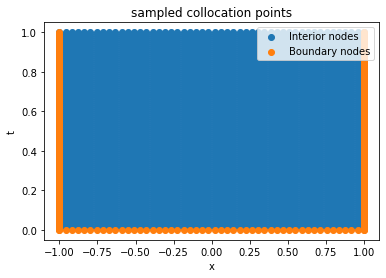

In [5]:
def sample_points(num_pts, dt, T, option = 'grid'):
    Nt = int(T/dt)+1
    X_domain = onp.zeros((Nt,num_pts,2))
    X_boundary = onp.zeros((Nt,2,2))
    if option == 'grid':
        for i in range(Nt):
            X_domain[i,:,0] = i*dt
            X_domain[i,:,1] = onp.linspace(-1.0,1.0, num_pts)
            X_boundary[i,:,0] = i*dt
            X_boundary[i,:,1] = [-1.0,1.0]
    return X_domain, X_boundary

# demonstration: show the collocation points
X_domain, X_boundary = sample_points(num_pts, dt, T, option = 'grid')
X_domain_tot = onp.reshape(X_domain[1:,:,:], (-1,2))
X_boundary_tot = onp.concatenate((onp.reshape(X_domain[0,:,:],(-1,2)), onp.reshape(X_boundary, (-1,2))),axis = 0)
fig, ax = plt.subplots()
ax.scatter(X_domain_tot[:, 1], X_domain_tot[:, 0], label='Interior nodes')
ax.scatter(X_boundary_tot[:, 1], X_boundary_tot[:, 0], label='Boundary nodes')
ax.legend(loc="upper right")
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.title('sampled collocation points')
plt.show()

In [6]:
def kappa(x1,y1,sigma):
    return jnp.exp(-(x1-y1)**2/(2*sigma**2))

def D_y1_kappa(x1,y1, sigma):
    val = grad(kappa,1)(x1, y1, sigma)
    return val

def Delta_y1_kappa(x1,y1, sigma):
    val = grad(D_y1_kappa,1)(x1, y1, sigma)
    return val


def D_x1_kappa(x1,y1, sigma):
    val = grad(kappa,0)(x1, y1, sigma)
    return val

def D_x1_D_y1_kappa(x1,y1, sigma):
    val = grad(D_x1_kappa,1)(x1, y1, sigma)
    return val

def D_x1_Delta_y1_kappa(x1,y1, sigma):
    val = grad(Delta_y1_kappa,0)(x1, y1, sigma)
    return val


def Delta_x1_kappa(x1,y1, sigma):
    val = grad(D_x1_kappa,0)(x1, y1, sigma)
    return val

def Delta_x1_D_y1_kappa(x1,y1, sigma):
    val = grad(Delta_x1_kappa,1)(x1, y1, sigma)
    return val

def Delta_x1_Delta_y1_kappa(x1,y1, sigma):
    val = grad(Delta_x1_D_y1_kappa,1)(x1, y1, sigma)
    return val

In [7]:
def assembly_Theta(X_domain, X_boundary, nugget, sigma):
    N_domain = onp.shape(X_domain)[0]
    N_boundary = onp.shape(X_boundary)[0]
    Theta = onp.zeros((3*N_domain+N_boundary, 3*N_domain+N_boundary))
    
    # auxiliary vector for construncting Theta
    # domain-domain
    XdXd = onp.tile(X_domain, (N_domain,1))
    XdXd_T = onp.transpose(XdXd) 
    
    XdXb1 = onp.transpose(onp.tile(X_domain,(N_domain+N_boundary,1)))
    X_all = onp.concatenate([X_domain,X_boundary])
    XdXb2 = onp.tile(X_all,(N_domain,1))
    
    XdbXdb = onp.tile(X_all,(N_domain+N_boundary,1))
    XdbXdb_T = onp.transpose(XdbXdb)
    
    val = vmap(lambda x1,y1: Delta_x1_Delta_y1_kappa(x1,y1, sigma))(XdXd_T.flatten(), XdXd.flatten())
    Theta[:N_domain,:N_domain] = onp.reshape(val, (N_domain,N_domain))
    
    val = vmap(lambda x1,y1: Delta_x1_D_y1_kappa(x1,y1, sigma))(XdXd_T.flatten(), XdXd.flatten())
    Theta[:N_domain,N_domain:2*N_domain] = onp.reshape(val, (N_domain,N_domain))
    Theta[N_domain:2*N_domain,:N_domain] = onp.transpose(onp.reshape(val, (N_domain,N_domain)))
    
    val = vmap(lambda x1,y1: Delta_x1_kappa(x1,y1, sigma))(XdXb1.flatten(), XdXb2.flatten())
    Theta[:N_domain,2*N_domain:] = onp.reshape(val,(N_domain,N_domain+N_boundary))
    Theta[2*N_domain:,:N_domain] = onp.transpose(onp.reshape(val,(N_domain,N_domain+N_boundary)))
    
    val = vmap(lambda x1,y1: D_x1_D_y1_kappa(x1,y1, sigma))(XdXd_T.flatten(), XdXd.flatten())
    Theta[N_domain:2*N_domain,N_domain:2*N_domain] = onp.reshape(val, (N_domain,N_domain))
    
    val = vmap(lambda x1,y1: D_x1_kappa(x1,y1, sigma))(XdXb1.flatten(), XdXb2.flatten())
    Theta[N_domain:2*N_domain,2*N_domain:] = onp.reshape(val,(N_domain,N_domain+N_boundary))
    Theta[2*N_domain:,N_domain:2*N_domain] = onp.transpose(onp.reshape(val,(N_domain,N_domain+N_boundary)))
    
    val = vmap(lambda x1,y1: kappa(x1,y1, sigma))(XdbXdb_T.flatten(), XdbXdb.flatten())
    Theta[2*N_domain:,2*N_domain:] = onp.reshape(val, (N_domain+N_boundary,N_domain+N_boundary))
    
    return Theta

    
def J_loss(v, rhs_f, bdy_g,L,dt):
    N_domain = onp.shape(rhs_f)[0]
    N_boundary = onp.shape(bdy_g)[0]
    
    vec_u = v[:N_domain]
    vec_u_x = v[N_domain:]
    vec_u_xx = (2/dt*vec_u+vec_u*vec_u_x-rhs_f)/nu
    vv = jnp.append(vec_u_xx,vec_u_x)
    vv = jnp.append(vv,vec_u)
    vv = jnp.append(vv,bdy_g)
    
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

grad_J = grad(J_loss)

def GN_J(v, rhs_f, bdy_g,L, dt, v_old):
    N_domain = onp.shape(rhs_f)[0]
    N_boundary = onp.shape(bdy_g)[0]
    
    vec_u_old = v_old[:N_domain]
    vec_u_x_old = v_old[N_domain:]
    
    vec_u = v[:N_domain]
    vec_u_x = v[N_domain:]
    vec_u_xx = (2/dt*vec_u+vec_u_old*vec_u_x+vec_u*vec_u_x_old-rhs_f)/nu
    vv = jnp.append(vec_u_xx,vec_u_x)
    vv = jnp.append(vv,vec_u)
    vv = jnp.append(vv,bdy_g)
    
    temp = jnp.linalg.solve(L,vv)
    return jnp.dot(temp, temp)

Hessian_GN=hessian(GN_J)

In [8]:
def time_steping_solve(X_domain, X_boundary, dt,T,num_pts,step_size = 1, nugget = 1e-10, sigma=0.2, GN_iteration = 4):
    Nt = int(T/dt)+1
    sol_u = onp.zeros((Nt,num_pts))
    sol_u_x = onp.zeros((Nt,num_pts))
    sol_u_xx = onp.zeros((Nt,num_pts))
    
    sol_u[0,:]=vmap(u)(X_domain[0,:,0],X_domain[0,:,1])
    sol_u_x[0,:]=vmap(u_x)(X_domain[0,:,0],X_domain[0,:,1])
    sol_u_xx[0,:]=vmap(u_xx)(X_domain[0,:,0],X_domain[0,:,1])
    
    Theta = assembly_Theta(X_domain[0,:,1], X_boundary[0,:,1], nugget, sigma)
    N_domain = num_pts
    N_boundary = 2
    trace1 = jnp.trace(Theta[:N_domain, :N_domain])
    trace2 = jnp.trace(Theta[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3 = jnp.trace(Theta[2*N_domain:, 2*N_domain:])
    ratio = [trace1/trace3, trace2/trace3]
    temp=jnp.concatenate((ratio[0]*jnp.ones((1,N_domain)),ratio[1]*jnp.ones((1,N_domain)),jnp.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*jnp.diag(temp[0])
    L = jnp.linalg.cholesky(Theta)
    for iter_i in range(Nt-1):
        # solve at t = (iter_i+1)*dt
        # get rhs_f and bdy_g
        rhs_f = 2/dt*sol_u[iter_i,:]-sol_u[iter_i,:]*sol_u_x[iter_i,:]+nu*sol_u_xx[iter_i,:]
        bdy_g = jnp.array([0,0])
        sol = jnp.append(sol_u[iter_i,:],sol_u_x[iter_i,:]) # initialization
        
        for iter_step in range(GN_iteration):
            temp = jnp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L,dt,sol), grad_J(sol,rhs_f,bdy_g,L,dt))
            sol = sol - step_size*temp
            
        sol_u[iter_i+1,:] = sol[:num_pts]
        sol_u_x[iter_i+1,:] = sol[num_pts:]
        sol_u_xx[iter_i+1,:] = (2/dt*sol[:num_pts]+sol[:num_pts]*sol[num_pts:]-rhs_f)/nu
        if iter_i % 5 ==1:
            print('Solved at time',dt*(iter_i+1),'\n')
    return sol_u 

In [9]:
dt = 4*1e-2
T = 1
Nt = int(T/dt) +1
num_pts = 400

X_domain, X_boundary = sample_points(num_pts, dt, T, option = 'grid')
sol_domain = time_steping_solve(X_domain, X_boundary, dt, T,num_pts,step_size = 1, nugget = 1e-13, sigma=0.01, GN_iteration = 2)

Solved at time 0.08 

Solved at time 0.28 

Solved at time 0.48 

Solved at time 0.68 

Solved at time 0.88 



In [10]:
# plot parameters
import matplotlib.ticker as ticker

fsize = 15
tsize = 15
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

In [11]:
# get the true solution

y_true = vmap(u_true)(X_domain[:,:,0].flatten(),X_domain[:,:,1].flatten())
y_true = onp.reshape(y_true, (Nt,num_pts))

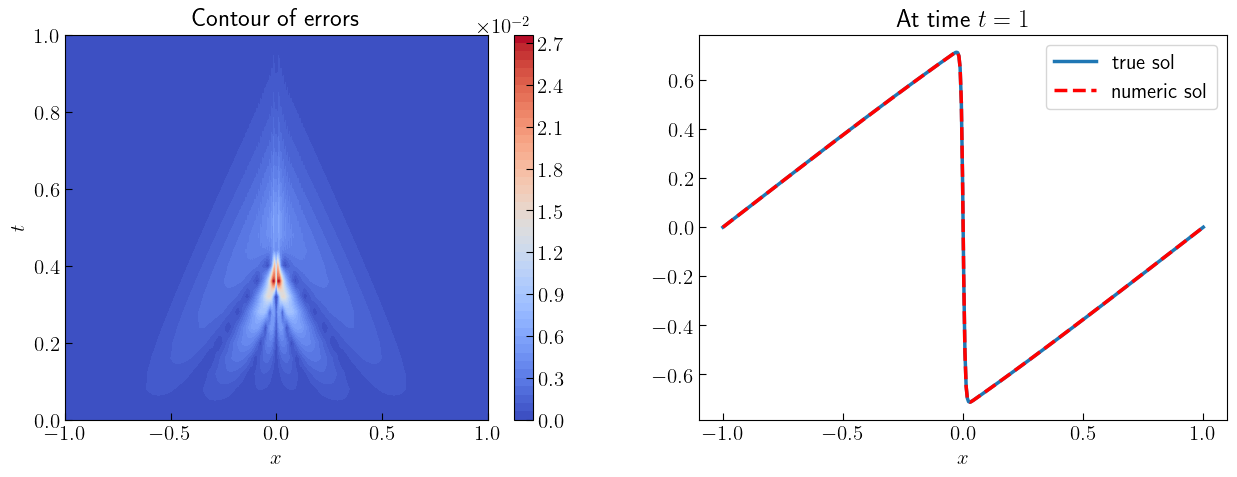

L2 err at t=1 is  0.00027011055617724304  and Max err is  0.0003889429195014227 



In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
err = abs(sol_domain[:,:]-y_true)
u_contourf=ax.contourf(X_domain[:,:,1], X_domain[:,:,0], err, 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Contour of errors')
fig.colorbar(u_contourf, format=fmt)


ax = fig.add_subplot(122)
ax.plot(X_domain[0,:,1], y_true[-1,:], linewidth=2.5, label='true sol')
ax.plot(X_domain[0,:,1], sol_domain[-1,:], linestyle='dashed', linewidth=2.5, color='red', label='numeric sol')
ax.set_xlabel('$x$')
ax.legend(loc="upper right")
plt.title('At time $t = 1$')

plt.show()
fig.tight_layout()

err_t_1 = err[-1,:]
L2err_t_1 = onp.sqrt(sum(err_t_1**2)/num_pts)
Maxerr_t_1 = max(err[-1,:])
print('L2 err at t=1 is ', L2err_t_1,' and Max err is ', Maxerr_t_1, '\n')

In [13]:
fig.savefig('Burgers_001pi.pdf', bbox_inches='tight',dpi=100,pad_inches=0.1)